# 勾配降下法による線型基底関数モデルの学習を自動微分ライブラリ（PyTorch）を用いて実装した例

## モジュールのインストール

Google Colabに標準でインストールされていないモジュールを最初にインストールしておく

In [1]:
!pip install torchviz
!pip install japanize-matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=57b066ad1ace881256b633a719248393b610e033d699b0331982745bbb82ec89
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 27.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=d0f7821e25d8254854ee211326539556d9f1a0575ef57dbd5ec441755a21b0a9
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


## 必要なモジュールの読み込み

可視化用のモジュール (Matplotlib) と自動微分の計算用モジュール (PyTorch)

In [2]:
from tqdm import tqdm
from matplotlib import pyplot as plt
import japanize_matplotlib

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F


print('PyTorch version: ' + torch.__version__)

PyTorch version: 2.1.0+cu121


## アルゴリズムの実行に使うトイデータの生成とプロット

第3回レポート課題で使用した三角関数回帰のデータ ($N = 100$) を用いる．

Text(0, 0.5, 'y')

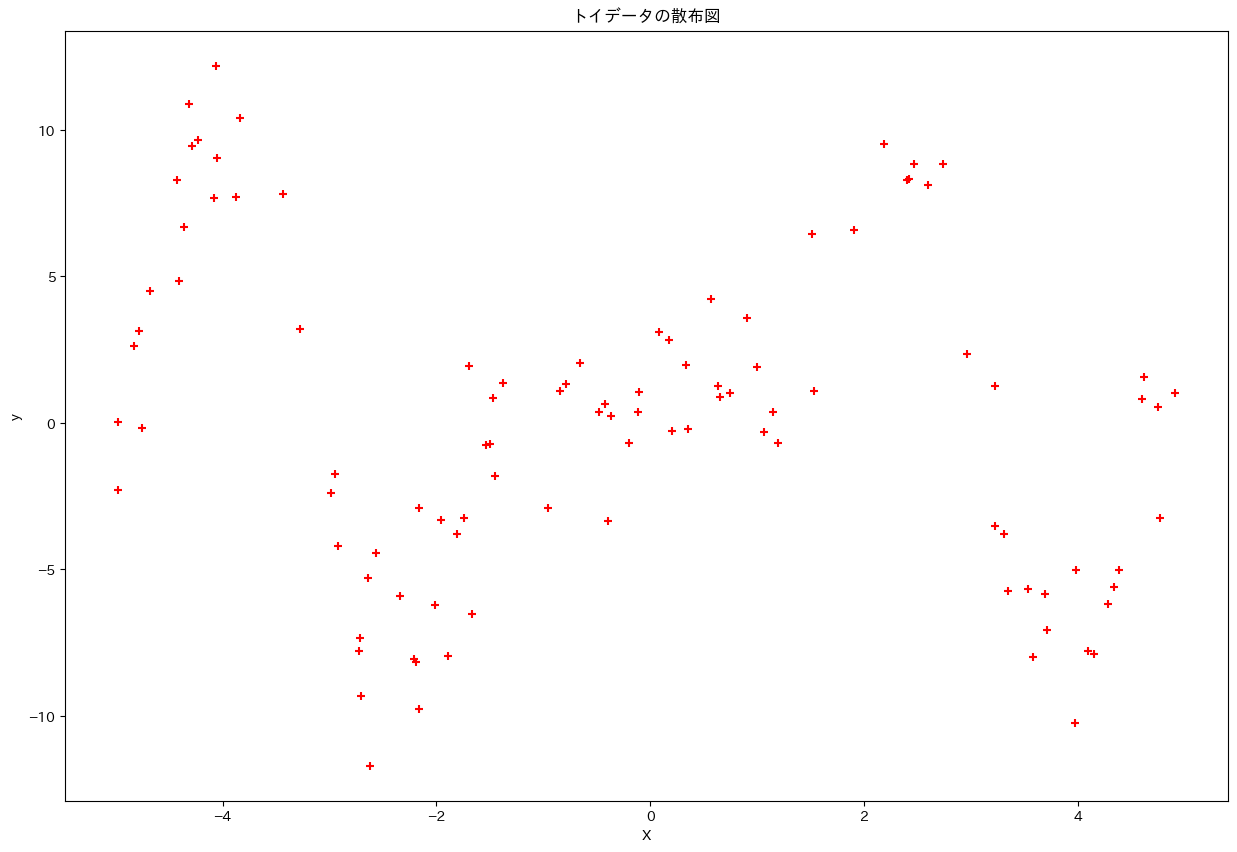

In [3]:
def generate_toydata(N=100):
    x = torch.rand(N) * 10.0 - 5.0
    e = torch.randn(N) * 2.0
    t = 1.0 + 4.0 * torch.sin(x) - 5.0 * torch.sin(2.0 * x) + 2.0 * torch.sin(3.0 * x) + e
    return x, t


X, y = generate_toydata()

plt.figure(figsize=(15, 10))
plt.scatter(X, y, marker='+', color='red')
plt.title('トイデータの散布図')
plt.xlabel('X')
plt.ylabel('y')

## モデルとデータ間の損失関数 (2乗誤差) の計算グラフを描画

* データ： $\{(x_n, t_n)\}_{n=1}^N$
* モデル: $y = a + b\sin x + c\sin 2x + d\sin 3x$
* 損失関数：
$$
\begin{align*}
L(a, b, c, d) &= \sum_{n=1}^N (t_n - y(x_n))^2 \\
&= \sum_{n=1}^N \left\{t_n - ( a + b\sin x + c\sin 2x + d\sin 3x)\right\}^2 \\
\end{align*}
$$

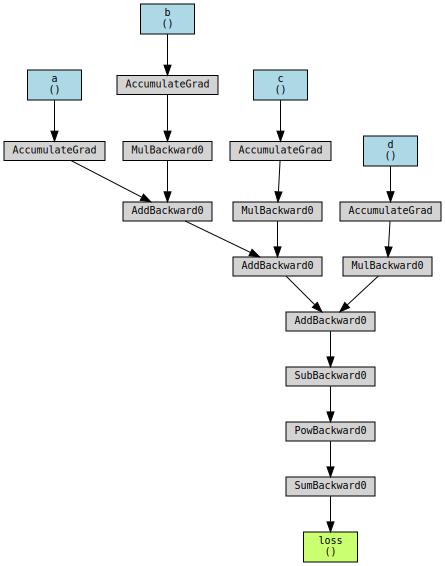

In [4]:
from torchviz import make_dot

# パラメタの初期値を設定（requires_gradは勾配を計算する必要がある変数，つまりパラメタであることを意味する）
a = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)
c = torch.tensor(1.0, requires_grad=True)
d = torch.tensor(1.0, requires_grad=True)

y_pred = a + b * torch.sin(X) + c * torch.sin(2.0 * X) + d * torch.sin(3.0 * X)
loss = torch.sum((y_pred - y) ** 2)

# 計算グラフの生成
dot = make_dot(loss, params={'a': a, 'b': b, 'c': c, 'd': d, 'loss': loss})
dot.graph_attr.update(size='12,24')

# 計算グラフの図をファイルに保存
dot.render('comp_graph', format='png')
dot.render('comp_graph', format='svg')

dot

## 勾配降下法による学習（損失関数を最小にする $a, b, c, d$ を探す）

In [5]:
# 学習率
lr = 1e-3

# パラメタの初期値を設定（requires_gradは勾配を計算する必要がある変数，つまりパラメタであることを意味する）
a = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)
c = torch.tensor(1.0, requires_grad=True)
d = torch.tensor(1.0, requires_grad=True)

# 勾配降下法の実行
for k in tqdm(range(5000)):
    # 各入力データに対するモデル予測の計算
    y_pred = a + b * torch.sin(X) + c * torch.sin(2.0 * X) + d * torch.sin(3.0 * X)
    # 損失関数の計算（モデルによる予測とデータの2乗誤差を計算する）
    loss = torch.sum((y_pred - y) ** 2)

    # 計算グラフを loss ノードから a, b, c, d ノードに向かって逆に辿ることで微分値を計算
    a.grad = torch.tensor(0.0)
    b.grad = torch.tensor(0.0)
    c.grad = torch.tensor(0.0)
    d.grad = torch.tensor(0.0)
    loss.backward()

    # 自動微分によって計算した微分値でパラメタの値を更新する
    # (ここでは計算グラフを作らないようにするため with torch.no_grad() の中で行う)
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
        c -= lr * c.grad
        d -= lr * d.grad

100%|██████████| 5000/5000 [00:01<00:00, 2756.15it/s]


In [6]:
# パラメタの学習結果
a, b, c, d

(tensor(0.8435, requires_grad=True),
 tensor(4.3860, requires_grad=True),
 tensor(-4.3258, requires_grad=True),
 tensor(2.4113, requires_grad=True))

## 学習したパラメタを使って回帰曲線を描画する

In [7]:
minval, maxval = -5.0, 5.0
n_samples = 1000

xx = torch.linspace(minval, maxval, n_samples)

with torch.no_grad():
    yy = a + b * torch.sin(xx) + c * torch.sin(2.0 * xx) + d * torch.sin(3.0 * xx)

Text(0, 0.5, 'y')

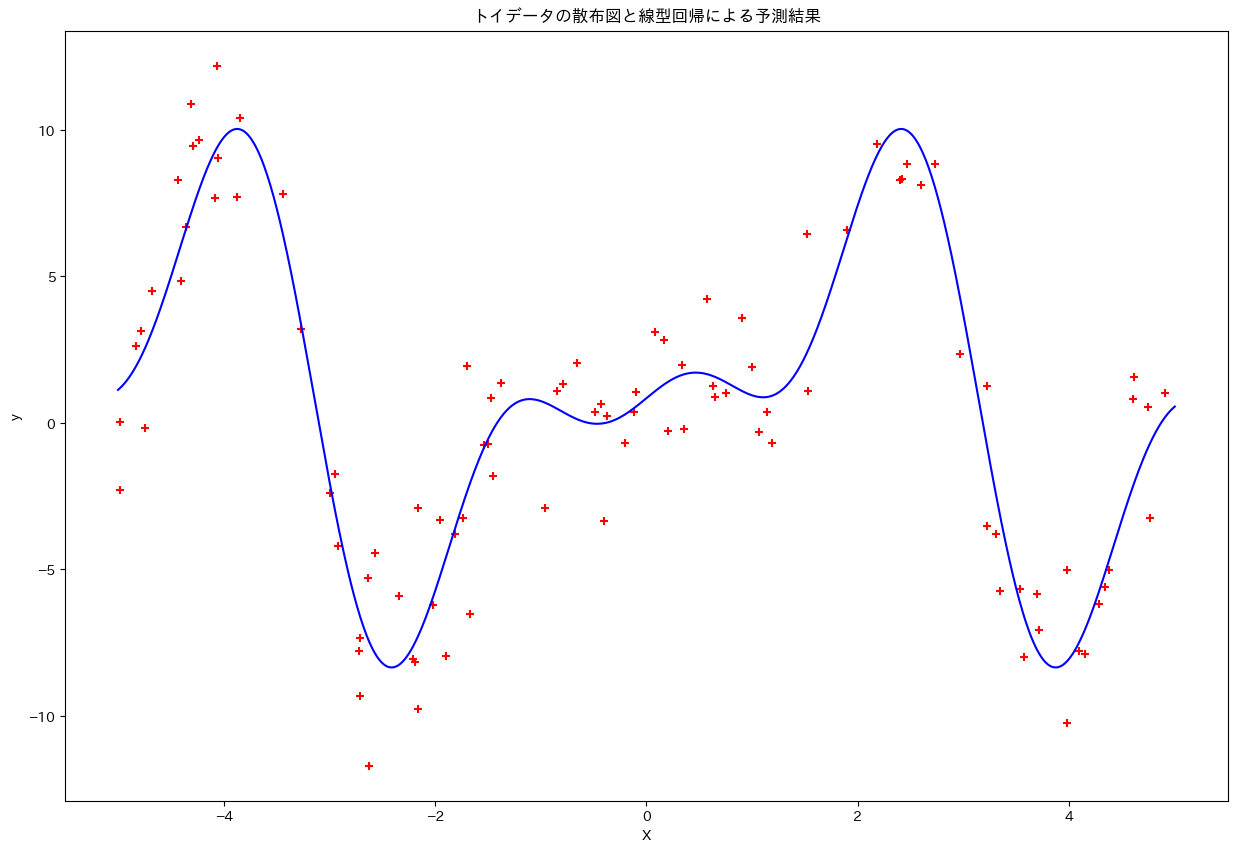

In [8]:
plt.figure(figsize=(15, 10))

plt.plot(xx, yy, color='blue')
plt.scatter(X, y, marker='+', color='red')

plt.title('トイデータの散布図と線型回帰による予測結果')
plt.xlabel('X')
plt.ylabel('y')